In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
import time
import copy

# Task 1

We define a recurrent neural network with the structure $$z_t = tanh(V z_{t-1} + U x_{t-1} + b) \tag{*}$$ 
$$x_t = W z_t + c \tag{**}$$
Graphically this network can be interpreted as follows: <br>

In [3]:
#img = mpimg.imread('latent_RNN.jpg')
#plt.figure(figsize=(img.shape[0] / float(25), img.shape[1] / float(25)))
#plt.imshow(img)
#plt.axis('off')
#plt.show()

# Task 2
We will now define and train this neural network to reproduce a mutivariate sinusoidal signal.

First we take a look at the signal the RNN is supposed to reproduce, it is a two dimensional sinusoidal signal.

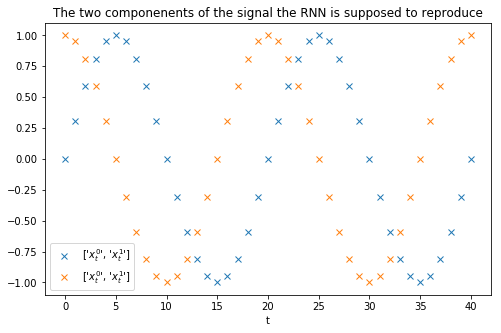

In [4]:
torch.autograd.set_detect_anomaly(True)

data = torch.load('sinus.pt')
observation_size = data.shape[1]

plt.figure(figsize = (8,5))
plt.title('The two componenents of the signal the RNN is supposed to reproduce')
plt.plot(data, marker = 'x', linestyle = ' ', label = ['$x^0_t$', '$x^1_t$'])
plt.xlabel('t')
plt.legend()
plt.show()

We can now implement the RNN with PyTorch:

In [3]:
class latent_RNN(torch.nn.Module):
    def __init__(self, obs_dim, latent_dim):
        super().__init__()
        
        self.x_size = obs_dim
        self.z_size = latent_dim
        
        self.rnn = torch.nn.RNN(input_size = self.x_size, hidden_size = self.z_size)
        self.W = torch.nn.Linear(in_features = self.z_size, out_features = self.x_size)

    def forward(self, inputs, z_0):
        z_t, z_T = self.rnn(inputs, z_0) # see (*)
        x_t = self.W(z_t)  # see (**)
        
        return x_t, z_T

For training the RNN we implement the following function, which will also make hyperparameter searches easier:

In [4]:
def train(model, epochs, learning_rate, momentum=0, adam=False, verbose=False):
    optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, momentum=momentum)
    if adam: optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    loss_function = torch.nn.MSELoss()
    
    losses = np.zeros(epochs)
    for i in range(epochs):
        h0 = torch.randn((1, model.z_size))
        x = data[:-1]  #x_0:T-1
        y = data[1:]   #x_1:T
        
        optimizer.zero_grad()               
        output, _ = model(x, h0)
        epoch_loss = loss_function(output, y)
        epoch_loss.backward()
        optimizer.step()
        
        losses[i] = epoch_loss.item()
        
        if (i % 100 == 0) and verbose:
            print("Epoch: {} loss {}".format(i, epoch_loss.item()))
     
    return losses

Some additional functions to evaluate the RNNs are also usefull:

In [5]:
# A function to generate a time series with the model
def generate_TS(model, N):
    z = torch.zeros((1, model.z_size))
    x_t = torch.zeros((N, model.x_size))
    x_t[:1] = data[:1]

    for t in range(1,N):
        x, z = model(x_t[t-1:t], z)
        x_t[t] = x
    
    return x_t.detach().numpy()

# A function to plot the time series resulting from the model
def evaluate(model):
    x = generate_TS(model, 6 * data.shape[0])
    
    plt.figure(figsize = (8,5))
    plt.title('The behavior of the NN compared to the target data')

    plt.plot(data, label = ['true $x^0$', 'true $x^1$'])
    plt.scatter(np.arange(0, 50), x[:50,0], marker = 'x', label = 'predicted $x^0$')
    plt.scatter(np.arange(0, 50), x[:50,1], marker = 'x', label = 'predicted $x^1$')

    plt.xlabel('t')
    plt.legend()
    plt.show()
    
    plt.figure(figsize = (8,5))
    plt.title('The long term behavior of the NN')

    plt.plot(x)

    plt.xlabel('t')
    plt.show()
    
# A function to evaluate multiple models
def evaluate_(models, titles):
    fig, axs = plt.subplots(len(models), 1, figsize=(8, 5 * len(models)))
    
    for i in range(len(models)):
        x = generate_TS(models[i], 2 * data.shape[0])
        
        axs[i].plot(data, label = ['true $x^0$', 'true $x^1$'])
        axs[i].scatter(np.arange(0, 50), x[:50,0], marker = 'x', label = 'predicted $x^0$')
        axs[i].scatter(np.arange(0, 50), x[:50,1], marker = 'x', label = 'predicted $x^1$')
        
        axs[i].set_title(titles[i])
    axs[-1].legend()

Now we want to find the smallest possible number of hidden neurons (dim(z)), we will achieve this by training mutliple networks with different latent dimensions and comparing them.

In [24]:
hidden_size = [1,2,3,4]

models, losses = [], []

for hidden in hidden_size:
    model = latent_RNN(observation_size, hidden)
    losses_ = train(model, epochs = 500, learning_rate = 0.1, verbose = False)
    
    models.append(model)
    losses.append(losses_)
    
    print(f'Done with {hidden}')
    
losses = np.array(losses)

Done with 1
Done with 2
Done with 3
Done with 4


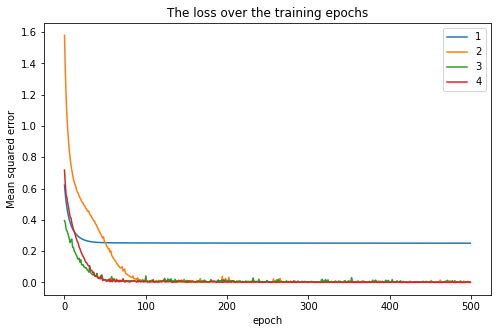

In [25]:
plt.figure(figsize = (8,5))
plt.title('The loss over the training epochs')

plt.plot(losses.T, label = hidden_size)

plt.xlabel('epoch')
plt.ylabel('Mean squared error')
plt.legend()
plt.show()

From this plot alone, we can see, that the model with 1 hidden neuron does not converge to a low loss value, 2 neurons seems to be enough already. <br>
But we can test this further:

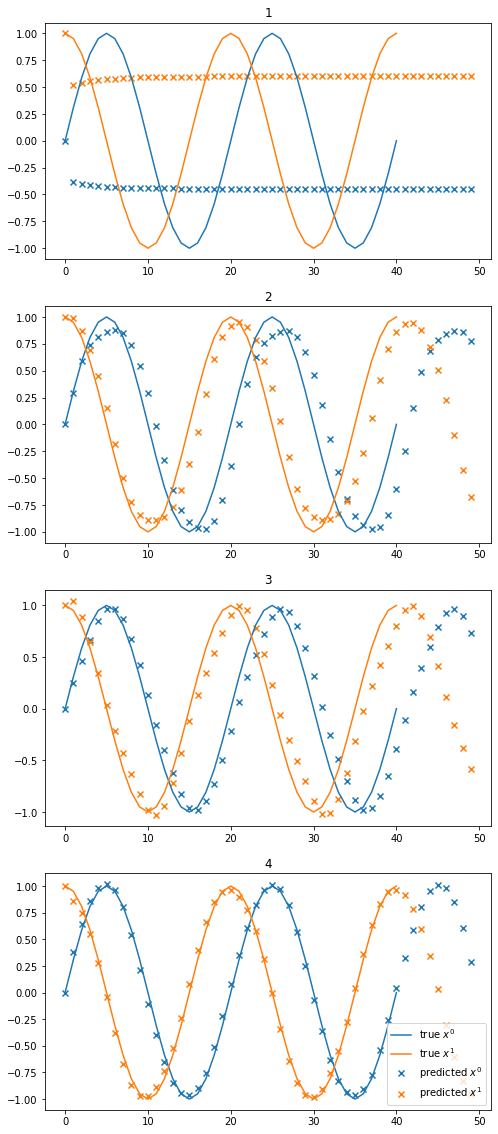

In [26]:
evaluate_(models, hidden_size)

It looks like 2 hidden neurons should already be enough. Thus we will use two hidden neurons in the following. <br>
Something to note is, that the smaller RNN take a little longer to converge.

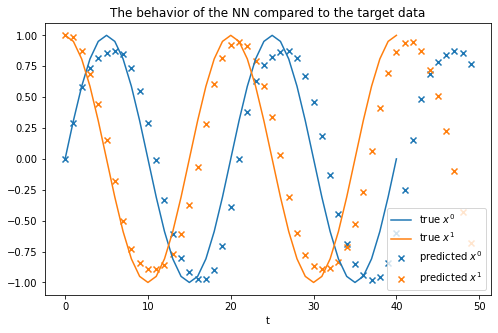

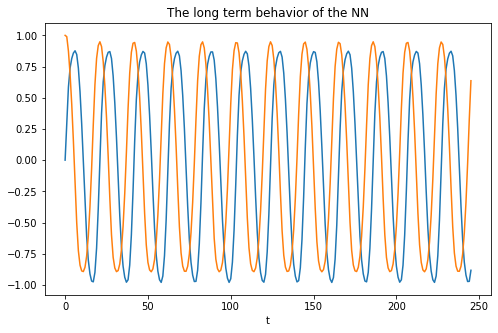

In [28]:
evaluate(models[1])

The longterm behavior of the RNN with 2 hidden neurons also looks good.

In [9]:
hidden_size = 2

# Task 3
In this task we will examine the training behavior of the model

## Task 3.1
First the dependency of the learning process on the learning rate. For that we train models with different learning rates and compare the results.

In [10]:
learning_rate = [0.001, 0.01, 0.1, 1]

models, losses = [], []

for lr in learning_rate:
    model = latent_RNN(observation_size, hidden_size)
    losses_ = train(model, 500, lr, verbose = False)
    models.append(model)
    losses.append(losses_)
    print(f'Done with {lr}')

losses = np.array(losses)

Done with 0.001
Done with 0.01
Done with 0.1
Done with 1


We can now plot the loss against the epochs:

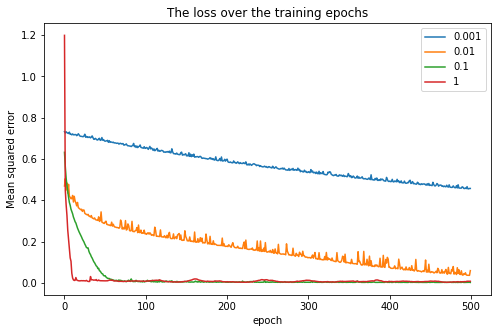

In [11]:
plt.figure(figsize = (8,5))
plt.title('The loss over the training epochs')

plt.plot(losses.T, label = learning_rate)

plt.xlabel('epoch')
plt.ylabel('Mean squared error')
plt.legend()
plt.show()

We can see that the bigger learning rates increase the speed of learning. While the two models with high learning rates train within 100 epochs the other two take more than 500 epochs to converge. However the model trained with a learning rate of 1 seems to jump past its local minimum leading to bumps in the loss curve even after convergence.

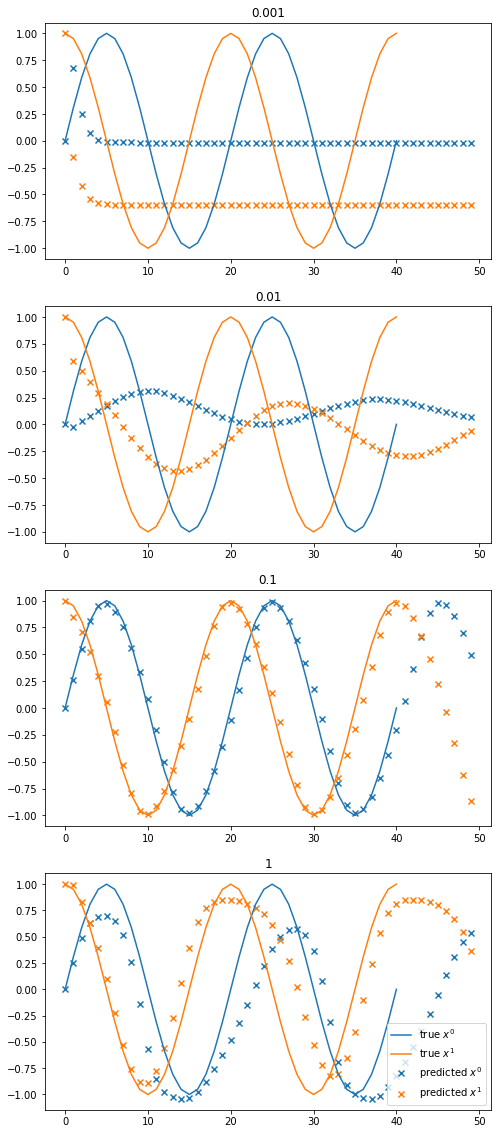

In [12]:
evaluate_(models, learning_rate)

This just illustrates what was said above. The models with very small learning rates have not yet converged, while the model with the biggest learning rate also does not properly converge, we suspect this is due to it moving beyond its minimum again and again.

## Task 3.2
The SGD algorithm has the option to enable momentum.

In [13]:
model = latent_RNN(observation_size, hidden_size)
loss = train(model, epochs = 200, learning_rate = 0.1, momentum=0.5, adam=False, verbose=True)

Epoch: 0 loss 0.9614715576171875
Epoch: 100 loss 0.01622588187456131


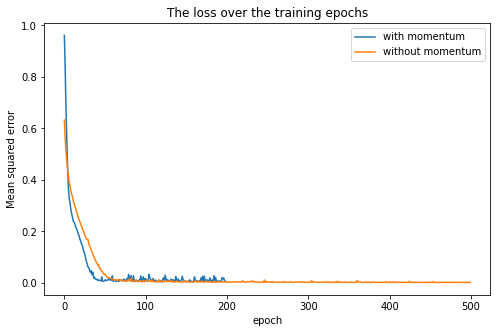

In [14]:
plt.figure(figsize = (8,5))
plt.title('The loss over the training epochs')

plt.plot(loss, label = 'with momentum')
plt.plot(losses[-2], label = 'without momentum')

plt.xlabel('epoch')
plt.ylabel('Mean squared error')
plt.legend()
plt.show()

With momentum enabled, the model takes a little less time to converge to its optimum. For this case its not particularly significant.

## Task 3.3
With the Adam optimizer instead:

In [15]:
model = latent_RNN(observation_size, hidden_size)
loss_ = train(model, epochs = 200, learning_rate = 0.1, adam=True, verbose=True)

Epoch: 0 loss 1.0828139781951904
Epoch: 100 loss 0.00436848308891058


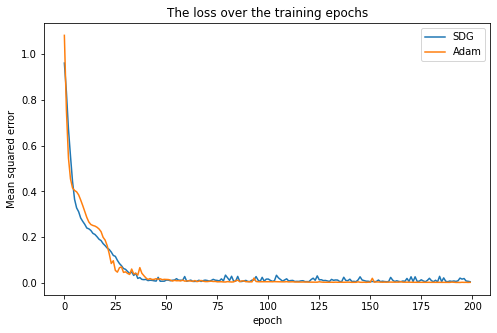

In [16]:
plt.figure(figsize = (8,5))
plt.title('The loss over the training epochs')

plt.plot(loss, label = 'SDG')
plt.plot(loss_, label = 'Adam')

plt.xlabel('epoch')
plt.ylabel('Mean squared error')
plt.legend()
plt.show()

The two optimizer perform very similarly. One difference I can make out is, that the training process of the Adam optimizer becomes smoother in the later epochs, which i would expect from the adaptive learning rate.

## Task 3.4
In this task we want to find bifurcations during the training process. For that we train a RNN but save copies of it at every training step to analyze later.

In [17]:
model = latent_RNN(observation_size, hidden_size)

snapshot = []

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_function = torch.nn.MSELoss()

epochs = 200
loss = np.zeros(200)
for i in range(200):
    h0 = torch.randn((1, model.z_size))
    x = data[:-1]  #x_0:T-1
    y = data[1:]   #x_1:T

    optimizer.zero_grad()               
    output, _ = model(x, h0)
    epoch_loss = loss_function(output, y)
    epoch_loss.backward()
    optimizer.step()
        
    loss[i] = epoch_loss.item()
    
    snapshot.append(copy.deepcopy(model)) # Make a copy and save it for analysis

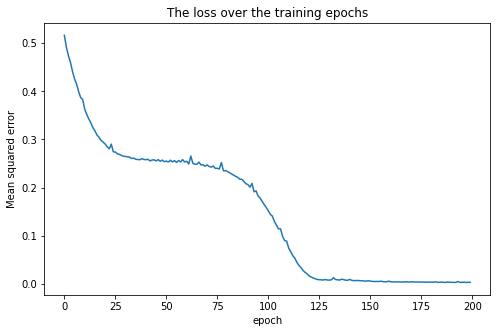

In [18]:
plt.figure(figsize = (8,5))
plt.title('The loss over the training epochs')

plt.plot(loss)

plt.xlabel('epoch')
plt.ylabel('Mean squared error')
plt.show()

I dont really understand what the task is asking us for here..? <br>
There are 3 points that I would suspect reflect bifurcation at 25, 80 and 120 epochs each. <br>
For this task we chose the one at 120 to visualize:

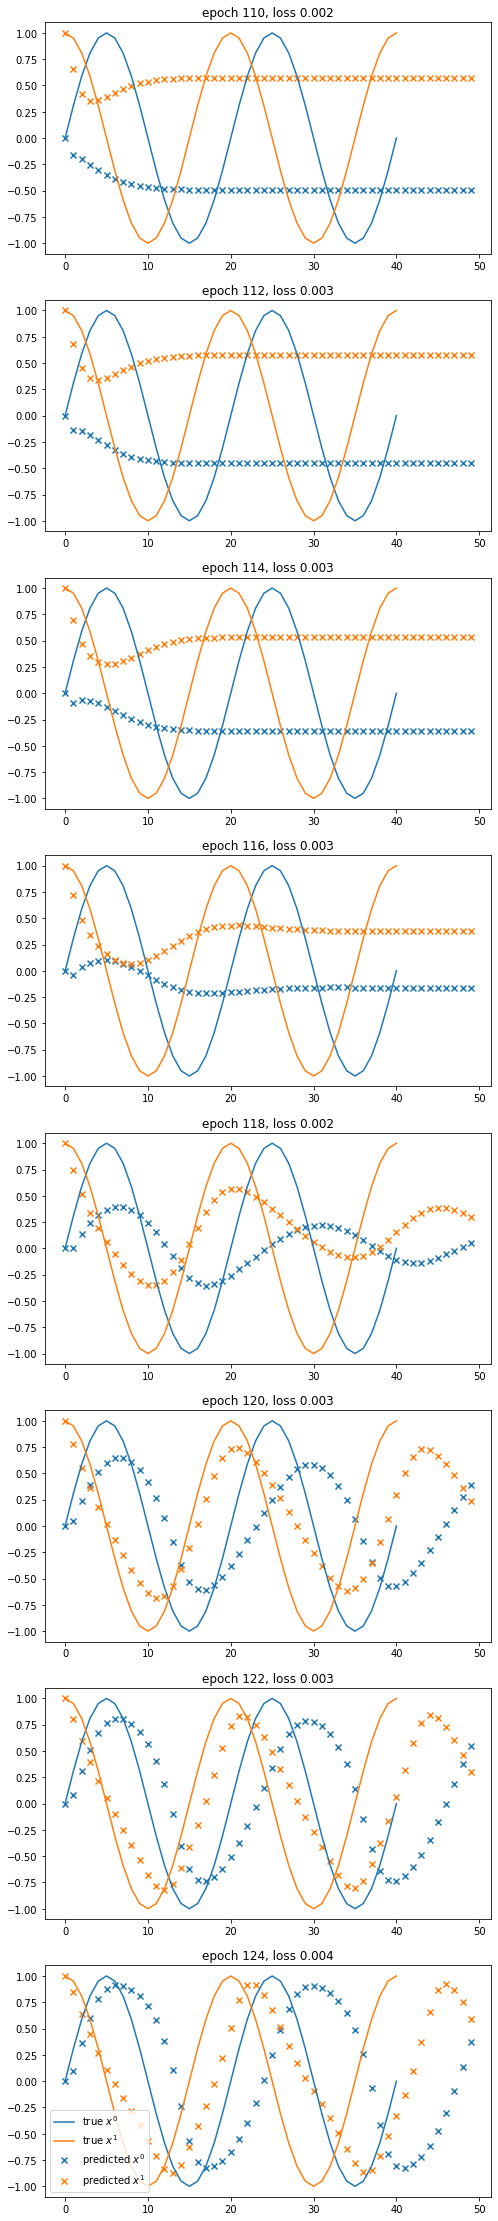

In [30]:
epochs = [110, 125]
evaluate_(snapshot[epochs[0]:epochs[1]:2], [f'epoch {i}, loss {loss[i]:.3f}' for i in range(epochs[0], epochs[1], 2)])

During these 15 epochs, the model seems to finally achieve oscillatory behavior which slowly starts matching the desired shape.

# Task 4
In the final task we implement minibaching which should increase the speed of training.

In [20]:
def train_minibatch(model, epochs, learning_rate, batch_number, sequence_lenght, verbose=False):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    loss_function = torch.nn.MSELoss()
    
    losses = np.zeros(epochs)
    for i in range(epochs):
        
        x = torch.zeros((sequence_lenght,batch_number,2))
        y = torch.zeros((sequence_lenght,batch_number,2))
        for j in range(batch_number):
            seq_start = np.random.randint(0, data.shape[0]-sequence_lenght-1)
            x[:,j,:] = data[seq_start:seq_start+sequence_lenght,:]
            y[:,j,:] = data[seq_start+1:seq_start+sequence_lenght+1,:]
        
        h0 = torch.randn((1, batch_number, model.z_size))
        
        optimizer.zero_grad()               
        output, _ = model(x, h0)
        epoch_loss = loss_function(output, y)
        epoch_loss.backward()
        optimizer.step()
        
        losses[i] = epoch_loss.item()
        
        if (i % 100 == 0) and verbose:
            print("Epoch: {} loss {}".format(i, epoch_loss.item()))
     
    return losses

In [21]:
model = latent_RNN(observation_size, hidden_size)
time_s = time.time_ns()
loss = train_minibatch(model, epochs = 500, learning_rate = 0.01, batch_number = 10, sequence_lenght = 5, verbose = True)
print(f'Total time {(time.time_ns()- time_s) * 1e-9} sec')

Epoch: 0 loss 0.43273553252220154
Epoch: 100 loss 0.0030484579037874937
Epoch: 200 loss 0.0027412401977926493
Epoch: 300 loss 0.0021008155308663845
Epoch: 400 loss 0.00140875403303653
Total time 14.941894800000002 sec


In [22]:
model = latent_RNN(observation_size, hidden_size)
time_s = time.time_ns()
loss_ = train(model, epochs = 500, learning_rate = 0.01, adam = True, verbose = True)
print(f'Total time {(time.time_ns() - time_s) * 1e-9} sec')

Epoch: 0 loss 1.0202264785766602
Epoch: 100 loss 0.06761534512042999
Epoch: 200 loss 0.006489929743111134
Epoch: 300 loss 0.0034874912817031145
Epoch: 400 loss 0.00244295597076416
Total time 76.1586831 sec


The speed up provided by minibatching is clear here: it takes the 'classical' training five times longer than the minibatch algorithm to train for 500 epochs.

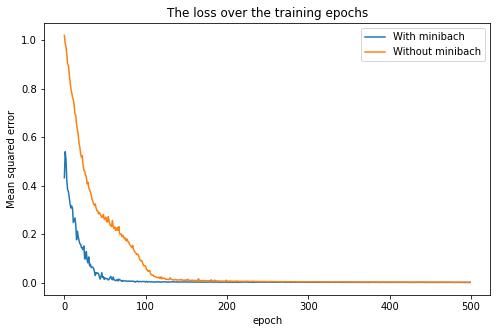

In [23]:
plt.figure(figsize = (8,5))
plt.title('The loss over the training epochs')

plt.plot(loss, label = 'With minibach')
plt.plot(loss_, label = 'Without minibach')

plt.xlabel('epoch')
plt.ylabel('Mean squared error')
plt.legend()
plt.show()

In addition to the quicker training computationally, the training also converges much faster with minibatching